In [1]:
from mpl_toolkits.mplot3d import Axes3D
from rtree import index
import xgboost as xgb
import pickle
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [2]:
%store -r mc_data

In [3]:
###### Data columns
i = 0
for val in mc_data.columns:
    print(i," ",val)
    i = i + 1

0   MCParticleID
1   MC_Hit_X
2   MC_Hit_Y
3   MC_Hit_Z
4   PrHit_LHCbID
5   PrHit_Xat0
6   PrHit_Zat0
7   PrHit_isX
8   PrHit_planeCode
9   PrHit_w2
10   PrHit_yMax
11   PrHit_yMin
12   PrHit_zone
13   event
14   hasT
15   isInUT
16   isInVelo
17   isLong
18   isLong_fromB
19   isLong_fromB_more5
20   isLong_more5


In [4]:
mc_hits = mc_data.values

In [5]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    seed_station_validation = load_model('./models/seed_station_validation.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [6]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    seeds_validation = load_model('./models/track_classifier_all_stations.h5')

In [7]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    predict_next_layer_from_track = load_model('./models/predict_next_layer_from_track.h5')

In [8]:
%store -r zLays
%store -r max_x
%store -r min_x
%store -r max_y
%store -r min_y
%store -r events
%store -r notValidParticles

In [9]:
print(events)

[15837 15838 15839 15840 15841 15842 15843 15844 15845 15846 15847 15848
 15849 15850 15851 15852 15853 15854 15855 15856 15857 15858 15859 15860
 15861 15862 15863 15864 15865 15866 15867 15868 15869 15870 15871 15872
 15873 15874 15875 15876 15877 15878 15879 15880 15881 15882 15883 15884
 15885 15886 15887 15888 15889 15890 15891 15892 15893 15894 15895 15896
 15897 15898 15899 15900 15901 15902 15903 15904 15905 15906 15907 15908
 15909 15910 15911 15912 15913 15914 15915 15916 15917 15918 15919 15920
 15921 15922 15923 15924 15925 15926 15927 15928 15929 15930 15931 15932
 15933 15934 15935 15936 15937 15938 15939 15940 15941 17909 17910 17911
 17912 17913 17914 17915 17916 17917 17918 17919 17920 17921 17922 17923
 17924 17925 17926 17927 17928 17929 17930 17931 17932 17933 17934 17935
 17936 17937 17938 17939 17940 17941 17942 17943 17944 17945 17946 17947
 17948 17949 17950 17951 17952 17953 17954 17955 17956 17957 17958 17959
 17960 17961 17962 17963 17964 17965 17966 17967 17

In [10]:
def histogram(data, color, min, max, title, x_axis, y_axis):
    fig = plt.figure(figsize=(19, 10))
    ax = fig.add_subplot(111)
    
    textstr = '$\mu=%.3f$\n$\sigma=%.3f$\n$n=%.0f$'%(np.mean(np.array(data)), np.std(np.array(data)), len(data))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=18,
            verticalalignment='top', bbox=props)

    n, bins, patches = plt.hist(data, 100, facecolor=color, range=(min,max))
    ax.set_title('%s\n' % title)
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.grid()
    plt.show()

In [11]:
def predictHeight(x0, x3, x_stereo, stereo_layer, first_layer, last_layer):
    
    z_stereo = zLays[stereo_layer]
    
    if (stereo_layer % 2 != 0):
        angle = 5
    else:
        angle = -5
    
    if (x3 - x0 == 0):
        m = 1
    else:
        m = (zLays[last_layer] - zLays[first_layer]) / (x3 - x0)
    n = zLays[last_layer] - (m * x3)
    
    x_pred = (z_stereo - n) / m 
    beta = (x_pred - x_stereo) / (math.radians(angle) * z_stereo)
    return math.tan(beta) * z_stereo

In [12]:
[211
 list([86.712600708, 100.1465072632, 113.7049179077, 127.3534851074, 221.315246582, 235.5047149658, 249.7422943115, 263.9998168945, 361.7663269043, 376.2708435059, 390.7873535156, 405.3469543457])
 list([-845.4118041992, -852.5712890625, -859.7599487305, -866.9368896484, -915.0144042969, -922.1186523438, -929.2175292969, -936.3226928711, -984.4196777344, -991.5267333984, -998.6636962891, -1005.7914428711])
 list([7822.955078125, 7892.9296875, 7962.904296875, 8032.87890625, 8504.7041015625, 8574.6787109375, 8644.654296875, 8714.62890625, 9189.4541015625, 9259.4296875, 9329.404296875, 9399.37890625])
 list([278855, 345442, 409737, 476695, 541526, 607036, 607033, 672388, 738304, 804220, 868606, 935058, 999896])
 list([86.7600021362, 174.5431976318, 38.4754219055, 127.4600067139, 221.3099975586, 315.7254333496, 316.3528442383, 168.3948059082, 264.0100097656, 361.4849853516, 463.0661315918, 303.3332824707, 405.4150085449])
 list([7825.9995117188, 7895.9995117188, 7966.0004882812, 8036.0004882812, 8507.9990234375, 8578, 8578, 8648, 8718.0009765625, 9192.9990234375, 9263, 9333, 9403.0009765625])
 list([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1])
 list([0, 1, 2, 3, 4, 5, 5, 6, 7, 8, 9, 10, 11])
 list([34.6020736694, 34.6020736694, 34.6020736694, 34.6020736694, 34.6020736694, 400, 400, 34.6020736694, 34.6020736694, 34.6020736694, 34.6020736694, 34.6020736694, 34.6020736694])
 list([-115.6211471558, 7.0269765854, -112.4825515747, -116.3773498535, -0.6218893528, -5.2309632301, -5.2854351997, -9.5531797409, -1.3780976534, -0.6218893528, -18.0235996246, 2.162655592, -1.3780976534])
 list([-2424.6062011719, -2407.7333984375, -2435.59375, -2425.3623046875, -2424.6062011719, -2419.9912109375, -2420.0456542969, -2424.3134765625, -2425.3623046875, -2424.6062011719, -2432.7839355469, -2412.59765625, -2425.3623046875])
 list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) 15837 True True True True
 False False False]

SyntaxError: invalid syntax (<ipython-input-12-b28e45037b41>, line 2)

In [ ]:
m = (zLays[0]) / float(86.7600021362)
n = zLays[0] - (m * 86.7600021362)
print((zLays[2] - n) / m )
beta = (x_pred - 174.5431976318) / (math.radians(5) * zLays[1])
math.tan(beta) * zLays[1]

In [ ]:
predictHeight(x0, x3, x_stereo, stereo_layer, first_layer, last_layer)

In [90]:
def selectValidCombinations(hit, arr_layer1, arr_layer2, arr_layer3, station, predictions):
    
    valid_combinations = []
    
    x0_layer = 0
    if (station == 1):
        x0_layer = 4
    else:
        x0_layer = 8
    u_layer = x0_layer + 1
    v_layer = x0_layer + 2
    x1_layer = x0_layer + 3
    
    if (len(arr_layer3) > 0) and len(arr_layer2) > 0 and len(arr_layer1) > 0:
        
        found_layer3 = sorted(arr_layer3, key=lambda x: np.abs(x[1]- predictions[2]))
        arr_layer3 = np.unique(np.array(found_layer3), axis=0)

        for h3 in arr_layer3:

            for h2 in arr_layer2:

                # Predict height for each hit selected in the V layer
                pred_h2 = predictHeight(hit[1], h3[1], h2[1], v_layer, x0_layer, x1_layer)

                if (pred_h2 > 0) and (pred_h2 > max_y) or (pred_h2 < 0) and (pred_h2 < min_y):
                    continue

                if (pred_h2 > 0) and h2[2] == 0 or (pred_h2 < 0) and h2[2] == 1:
                    continue

                for h1 in arr_layer1:

                    # Predict height for hit in the U layer
                    pred_h1 = predictHeight(hit[1], h3[1], h1[1], u_layer, x0_layer, x1_layer)

                    if (pred_h1 > 0) and (pred_h1 > max_y) or (pred_h1 < 0) and (pred_h1 < min_y):
                        continue

                    if (pred_h1 > 0) and h1[2] == 0 or (pred_h1 < 0) and h1[2] == 1:
                        continue

                    if np.abs(pred_h2 - pred_h1) < 26:
                        seed = [hit[1], h1[1], pred_h1, h2[1], pred_h2, h3[1], station, (hit[3], h1[3], h2[3], h3[3]), (hit[0], h1[0], h2[0], h3[0])]
                        #acc = seed_station_validation.predict(np.array(seed[:7]).reshape(1,-1))
                        valid_combinations.append(seed)

    else:
        if len(arr_layer3) == 0 and (len(arr_layer2) > 0) and (len(arr_layer1) > 0): 
            for h2 in arr_layer2:
                for h1 in arr_layer1:
                    seed = [hit[1], h1[1], 0, h2[1], 0, predictions[2], station, (hit[3], h1[3], h2[3], 0), (hit[0], h1[0], h2[0], 0)]
                    valid_combinations.append(seed)
        elif len(arr_layer3) == 0 and len(arr_layer2) > 0:
            for h2 in arr_layer2:
                seed = [hit[1], predictions[1], 0, h2[1], 0, predictions[2], station, (hit[3], 0, h2[3], 0), (hit[0], h1[0], h2[0], 0)]
                valid_combinations.append(seed)
        elif len(arr_layer3) == 0 and len(arr_layer1) > 0:
            for h1 in arr_layer1:
                seed = [hit[1], h1[1], 0, predictions[1], 0, predictions[2], station, (hit[3], h1[3], 0, 0), (hit[0], h1[0], h2[0], 0)]
                valid_combinations.append(seed)
        elif len(arr_layer1) > 0 and len(arr_layer2) == 0:
            for h3 in arr_layer3:
                for h1 in arr_layer1:
                    pred_h1 = predictHeight(hit[1], h3[1], h1[1], u_layer, x0_layer, x1_layer)

                    if (pred_h1 > 0) and (pred_h1 > max_y) or (pred_h1 < 0) and (pred_h1 < min_y):
                        continue
                    if (pred_h1 > 0) and h1[2] == 0 or (pred_h1 < 0) and h1[2] == 1:
                        continue

                    seed = [hit[1], h1[1], pred_h1, predictions[1], 0, h3[1], station, (hit[3], h1[3], 0, h3[3])]
                    valid_combinations.append(seed)
        elif len(arr_layer2) > 0 and len(arr_layer1) == 0:
            for h3 in arr_layer3:
                for h2 in arr_layer2:

                    pred_h2 = predictHeight(hit[1], h3[1], h2[1], v_layer, x0_layer, x1_layer)

                    if (pred_h2 > 0) and (pred_h2 > max_y) or (pred_h2 < 0) and (pred_h2 < min_y):
                        continue
                    if (pred_h2 > 0) and h2[2] == 0 or (pred_h2 < 0) and h2[2] == 1:
                        continue

                    seed = [hit[1], predictions[0], 0, h2[1], pred_h2, h3[1], station, (hit[3], 0, h2[3], h3[3]), (hit[0], 0, h2[0], h3[0])]
                    valid_combinations.append(seed)
                    
    return valid_combinations

In [91]:
def calculateMinMaxHeight(track):
    if (track[2] == 0 and track[4] == 0):
        min_h = 0
        max_h = 0
    elif track[2] == 0:
        min_h = track[4]
        max_h = track[4]
    elif track[4] == 0:
        min_h = track[4]
        max_h = track[4]
    else:
        if track[2] > track[4]:
            min_h = track[4]
            max_h = track[2]
        else:
            min_h = track[2]
            max_h = track[4]
    return min_h, max_h

In [92]:
def validateTracks(track1, track2):
    found = 0
    num1 = np.argmax(np.bincount(track1[7]))
    num2 = np.argmax(np.bincount(track1[7]))
    if num1 == num2 and track1[7].count(num1) > 1 and track2[7].count(num2) > 1:
        if track1[7][1] == num1 or track1[7][2] == num1:
            found += 1
        if track1[7][0] == num1 or track1[7][3] == num1:
            found += 1
        if track2[7][0] == num1 or track2[7][3] == num1:
            found += 1
        if track2[7][1] == num1 or track2[7][2] == num1:
            found += 1
    return found > 3

In [93]:
def validTrackThird_NN(track1, track2, valid_tracks):
    max = 0
    selected = None
    if (len(valid_tracks) > 0):
        selected = valid_tracks[0]
        for track in valid_tracks:
            pred = seeds_validation.predict(np.concatenate((track1[:6],track2[:6],track[:6])).reshape(1,-1))
            if (pred > max):
                max = pred
                selected = track
    return selected, max

In [94]:
def stationIds(station):
    x0_layer = 0
    if (station == 1):
        x0_layer = 4
    elif (station == 2):
        x0_layer = 8
        
    u_layer = x0_layer + 1
    v_layer = x0_layer + 2
    x1_layer = x0_layer + 3
    return x0_layer, u_layer, v_layer, x1_layer

In [95]:
def sortTrack(track, compare):
    if (track[2] == 0):
        return np.abs(track[4] - compare)
    else:
        return np.abs(track[2] - compare)

In [96]:
#
# Test the NN model by using events not feeded as train 
#
max_hits_gathered = 15

def seedSecondStation(hit_tree, seed_tree, num_particles):
    
    # Variable defining the maximum number of hits gathered from the R-trees when using the predicted value from the NN
    found_total = invalid_found_first = 0

    
    limit = 80
    
    station = 1
        
    px0_layer, pu_layer, pv_layer, px1_layer = stationIds(station - 1)
    previous_station_seeds = list(seed_tree.intersection((min_x, max_x, min_y, max_y, station - 1, station - 1), objects='raw'))
    
    x0_layer, u_layer, v_layer, x1_layer = stationIds(station)
    hits_station = list(hit_tree.intersection((min_x, max_x, x0_layer, x0_layer, 0, 1), objects='raw'))
    ghost = 0
    
    for seed in previous_station_seeds:
        
        if (seed[5] == 0):
            m = (zLays[px0_layer]) / (seed[0])
        else:
            m = (zLays[px1_layer] - zLays[px0_layer]) / (seed[5] - seed[0])
            
        n = zLays[px0_layer] - (m * seed[0])
        loc = (zLays[x0_layer] - n) / m 
        
        fzone = 0
        
        predicted = np.zeros(3)
        hfound = list(hit_tree.intersection((loc - 100, loc + 100, x0_layer, x0_layer, fzone, fzone), objects='raw'))
        
        for hit in hfound:
            
            valid_tracks = []
            first_hit = hit[1]
            zone = hit[2]

            predicted = np.zeros(3)

            predicted[0] = (zLays[u_layer] - n) / m 

            found = list(hit_tree.intersection((predicted[0] - limit, predicted[0] + limit, u_layer, u_layer, zone, zone), objects='raw'))

            if (len(found) > 0):
                found_layer1 = sorted(found, key=lambda x: np.abs(x[1] - predicted[0]))[:max_hits_gathered]
                arr_layer1 = np.unique(np.array(found_layer1), axis=0)
            else:
                arr_layer1 = found

            predicted[1] = (zLays[v_layer] - n) / m 

            found = list(hit_tree.intersection((predicted[1] - limit, predicted[1] + limit, v_layer, v_layer, zone, zone), objects='raw'))

            if (len(found) > 0):
                found_layer2 = sorted(found, key=lambda x: np.abs(x[1] - predicted[1]))[:max_hits_gathered]
                arr_layer2 = np.unique(np.array(found_layer2), axis=0)
            else:
                arr_layer2 = found

            predicted[2] = (zLays[x1_layer] - n) / m 

            found = list(hit_tree.intersection((predicted[2] - limit, predicted[2] + limit, x1_layer, x1_layer, zone, zone), objects='raw'))

            valid_combinations = selectValidCombinations(hit, arr_layer1, arr_layer2, found, station, predicted)

            if len(valid_combinations) > 0:

                compare = seed[2]
                if (compare == 0):
                    compare = seed[4]
                
                found = False
                valid_tracks = sorted(valid_combinations, key = lambda p: sortTrack(p, compare))
                for val in valid_tracks:
                    value = val[2]
                    if (value == 0):
                        value = val[4]
                    if (np.abs(value - compare) < 80):
                        valid = val
                        found = True
                        break
                
                if (found):
                    found = 0
                    if valid[7][0] == valid[7][2] or valid[7][0] == valid[7][1]:
                        found += 1
                    if valid[7][0] == valid[7][3]:
                        found += 1
                    if valid[7][3] == valid[7][2] or valid[7][3] == valid[7][1]:
                        found += 1
                    if found > 0:
                        found_total += 1
                    else:
                        ghost += 1

                    min_h, max_h = calculateMinMaxHeight(valid)
                    seed_tree.insert(int(hit[1]), (hit[1], hit[1], min_h, max_h, station, station), [valid, seed])
    
    
    return found_total/len(previous_station_seeds), ghost/len(previous_station_seeds)

In [97]:
#
# Test the NN model by using events not feeded as train 
#
max_hits_gathered = 15

def seedThirdStation(hit_tree, seed_tree, num_particles):
    
    # Variable defining the maximum number of hits gathered from the R-trees when using the predicted value from the NN
    found_total = invalid_found_first = 0

    
    limit = 80
    
    station = 2
        
    px0_layer, pu_layer, pv_layer, px1_layer = stationIds(station - 1)
    previous_station_seeds = list(seed_tree.intersection((min_x, max_x, min_y, max_y, station - 1, station - 1), objects='raw'))
    
    x0_layer, u_layer, v_layer, x1_layer = stationIds(station)
    hits_station = list(hit_tree.intersection((min_x, max_x, x0_layer, x0_layer, 0, 1), objects='raw'))
        
    tracks = []
    ghost = 0
    
    final_seeds = []
    
    for mseed in previous_station_seeds:
        
        seed = mseed[0]
        if (seed[5] == 0):
            if (mseed[1][5] == 0):
                m = (zLays[px0_layer] - zLays[0]) / (seed[0] - mseed[1][0])
            else:
                m = (zLays[px0_layer] - zLays[3]) / (seed[0] - mseed[1][5])
        else:
            m = (zLays[px1_layer] - zLays[px0_layer]) / (seed[5] - seed[0])
       
        n = zLays[px0_layer] - (m * seed[0])
        loc = (zLays[x0_layer] - n) / m 
        
        fzone = 0
        
        predicted = np.zeros(3)
        hfound = list(hit_tree.intersection((loc - 100, loc + 100, x0_layer, x0_layer, fzone, fzone), objects='raw'))
        
        valid_seeds = []
        
        for hit in hfound:
            
            valid_tracks = []
            first_hit = hit[1]
            zone = hit[2]

            predicted = np.zeros(3)

            predicted[0] = (zLays[u_layer] - n) / m 

            found = list(hit_tree.intersection((predicted[0] - limit, predicted[0] + limit, u_layer, u_layer, zone, zone), objects='raw'))

            if (len(found) > 0):
                found_layer1 = sorted(found, key=lambda x: np.abs(x[1] - predicted[0]))[:max_hits_gathered]
                arr_layer1 = np.unique(np.array(found_layer1), axis=0)
            else:
                arr_layer1 = found

            predicted[1] = (zLays[v_layer] - n) / m 

            found = list(hit_tree.intersection((predicted[1] - limit, predicted[1] + limit, v_layer, v_layer, zone, zone), objects='raw'))

            if (len(found) > 0):
                found_layer2 = sorted(found, key=lambda x: np.abs(x[1] - predicted[1]))[:max_hits_gathered]
                arr_layer2 = np.unique(np.array(found_layer2), axis=0)
            else:
                arr_layer2 = found

            predicted[2] = (zLays[x1_layer] - n) / m 

            found = list(hit_tree.nearest((predicted[2] - limit, predicted[2] + limit, x1_layer, x1_layer, zone, zone), objects='raw'))

            valid_combinations = selectValidCombinations(hit, arr_layer1, arr_layer2, found, station, predicted)

            if len(valid_combinations) > 0:

                compare = seed[2]
                if (compare == 0):
                    compare = seed[4]
                
                found = False
                
                valid_tracks = sorted(valid_combinations, key = lambda p: sortTrack(p, compare))
                for val in valid_tracks:
                    value = val[4]
                    if (value == 0):
                        value = val[2]
                    if (np.abs(value - compare) < 80):
                        valid = val
                        found = True
                        break
                
                if (found):
                    found = 0
                    if valid[7][0] == valid[7][2] or valid[7][0] == valid[7][1]:
                        found += 1
                    if valid[7][0] == valid[7][3]:
                        found += 1
                    if valid[7][3] == valid[7][2] or valid[7][3] == valid[7][1]:
                        found += 1
                    if found > 0:
                        found_total += 1
                    else:
                        ghost += 1

                    min_h, max_h = calculateMinMaxHeight(valid)
                    seed_tree.insert(int(hit[1]), (hit[1], hit[1], min_h, max_h, station, station), [valid, mseed]) 
        
    return found_total/len(previous_station_seeds), ghost/len(previous_station_seeds)

In [106]:
#
# Test the NN model by using events not feeded as train 
#
max_hits_gathered = 15

def seedFirstStation(hit_tree, seed_tree, num_particles):
    
    # Variable defining the maximum number of hits gathered from the R-trees when using the predicted value from the NN
    found_total = invalid_found_first = 0
    
    station = 0
    
    x0_layer, u_layer, v_layer, x1_layer = stationIds(station)
    
    limit = 100
        
    hits_station = list(hit_tree.intersection((min_x, max_x, x0_layer, x0_layer, 0, 1), objects='raw'))
        
    tracks = []
    emtpy = 0
    ghost = 0
    
    final_seeds = []
    
    for hit in hits_station:
       
        valid_tracks = []
        first_hit = hit[1]
        zone = hit[2]
        m = zLays[x0_layer] / first_hit
        n = zLays[x0_layer] - (m * first_hit)
        
        predicted = np.zeros(3)

        #predicted = (xlayer_model.predict(np.array([first_hit, x0_layer]).reshape(1,-1)))[0]
        #mean_predicted = ((first_hit + predicted[0] + predicted[1] + predicted[2]) / 4)
        
        predicted[0] = (zLays[u_layer] - n) / m 

        found = list(hit_tree.intersection((predicted[0] - limit, predicted[0] + limit, u_layer, u_layer, zone, zone), objects='raw'))
        
        if (len(found) > 0):
            arr_layer1 = np.unique(np.array(found), axis=0)
        else:
            arr_layer1 = found
            
        predicted[1] = (zLays[v_layer] - n) / m 

        found = list(hit_tree.intersection((predicted[1] - limit, predicted[1] + limit, v_layer, v_layer, zone, zone), objects='raw'))
        
        if (len(found) > 0):
            arr_layer2 = np.unique(np.array(found), axis=0)
        else:
            arr_layer2 = found
            
        predicted[2] = (zLays[x1_layer] - n) / m 
        
        found = list(hit_tree.nearest((predicted[2] - limit, predicted[2] + limit, x1_layer, x1_layer, zone, zone), objects='raw'))
       
        valid_combinations = selectValidCombinations(hit, arr_layer1, arr_layer2, found, station, predicted)
        
        if len(valid_combinations) > 0:
            
            valid = valid_combinations[0]
            max = seed_station_validation.predict(np.array([valid[:7]]).reshape(1,-1))[0]
            for val in valid_combinations:
                acc = seed_station_validation.predict(np.array([val[:7]]).reshape(1,-1))[0]
                if acc > max:
                    valid = val
                    max = acc
            
            found = 0
            if valid[7][0] == valid[7][2] or valid[7][0] == valid[7][1]:
                found += 1
            if valid[7][0] == valid[7][3]:
                found += 1
            if valid[7][3] == valid[7][2] or valid[7][3] == valid[7][1]:
                found += 1
            if found > 0:
                found_total += 1
            else:
                ghost += 1
            
            min_h, max_h = calculateMinMaxHeight(valid)
            seed_tree.insert(int(hit[1]), (hit[1], hit[1], min_h, max_h, station, station), valid)
    
    return found_total/length_valid, ghost/length_valid

In [107]:
import time

mean = ghosts = done = 0
test_events = events[1:3]

X_classifier = []
Y_classifier = []

p_hits = index.Property()
p_hits.dimension = 3

for event in test_events:
    particles_test_event = mc_hits[mc_hits[:,13] == event]
    
    hit_tree = index.Index(properties=p_hits, interleaved=False)
    seed_tree = index.Index(properties=p_hits, interleaved=False)
    
    seeds = [[], [], []]
    found = np.zeros(3)
    ghost = np.zeros(3)
    
    length_valid = 0
    for j in range(0, len(particles_test_event)):
        hit = particles_test_event[j]
        if (len(hit[5]) > 1) and not hit[0] in notValidParticles:
            if (hit[12][0] == 0):
                length_valid += 1
                for i in range(0,len(hit[5])):
                    hit_store = [hit[4][i], hit[5][i], hit[12][i], j]
                    hit_tree.insert(int(hit[4][i]), (float(hit[5][i]), float(hit[5][i]), hit[8][i], hit[8][i], hit[12][i], hit[12][i]), hit_store)
    
    print('Starting Seeding')
    
    found[0], ghost[0] = seedFirstStation(hit_tree, seed_tree, length_valid)
    
    first_seeds = list(seed_tree.intersection((min_x, max_x, min_y, max_y, 0, 0), objects='raw'))
    print('Found in first %d' % len(first_seeds))
    
    found[1], ghost[1] = seedSecondStation(hit_tree, seed_tree, length_valid)
    
    first_seeds = list(seed_tree.intersection((min_x, max_x, min_y, max_y, 1, 1), objects='raw'))
    print('Found in second %d' % len(first_seeds))
    
    found[2], ghost[2] = seedThirdStation(hit_tree, seed_tree, length_valid)
    
    first_seeds = list(seed_tree.intersection((min_x, max_x, min_y, max_y, 2, 2), objects='raw'))
    
    print('Finishing Seeding')
    print('Found possible %d seeds ' % (len(first_seeds)))
    
    valid = 0
    selected = {}
    
    fifty = 0
    for fseed in first_seeds:
        if not fseed[1][0][8][0] in selected:
            selected[fseed[1][0][8][0]] = fseed[1][0][8]
        else:
            if selected[fseed[1][0][8][0]] == fseed[1][0][8]:
                continue
                
        if validateTracks(fseed[1][0], fseed[0]) and validateTracks(fseed[1][1], fseed[0]):
            valid += 1
                    
    print(valid/length_valid)
    print(fifty/len(first_seeds))
    print(len(first_seeds))
    
    event_acc = np.mean(found)
    event_ghosts = np.mean(ghost)
    
    mean += event_acc
    ghosts += event_ghosts
    done += 1
    
    print("Event %d/%d \t Total acc: %f Ghost: %f \t All Accs: %s" % (done,len(test_events), event_acc, event_ghosts, found))
    
print("\nFinal Result:")
print("\t Mean: %f" % (mean/len(test_events)))
print("\t Ghosts: %f" % (ghosts/len(test_events)))

Starting Seeding
Found in first 40
Found in second 137
Finishing Seeding
Found possible 451 seeds 
0.6122448979591837
0.0
451
Event 1/2 	 Total acc: 2.054813 Ghost: 0.456286 	 All Accs: [0.73469388 2.875      2.55474453]
Starting Seeding
Found in first 50
Found in second 73
Finishing Seeding
Found possible 138 seeds 
0.3684210526315789
0.0
138
Event 2/2 	 Total acc: 1.187346 Ghost: 0.221855 	 All Accs: [0.71929825 1.24       1.60273973]

Final Result:
	 Mean: 1.621079
	 Ghosts: 0.339071


In [251]:
len(X_classifier)

1991

In [190]:
valid = 0
selected = {}
for fseed in first_seeds:
    if not fseed[1][0][8][0] in selected:
        selected[fseed[1][0][8][0]] = fseed[1][0][8]
    else:
        if selected[fseed[1][0][8][0]] == fseed[1][0][8]:
            continue
    
    m1 = (zLays[11] - zLays[8]) / (fseed[0][5] - fseed[0][0])
    m2 = (zLays[7] - zLays[4]) / (fseed[1][1][5] - fseed[1][0][0])
    
    print(fseed)
    print(m1, m2)
    print(validateTracks(fseed[1][0], fseed[0]) and validateTracks(fseed[1][1], fseed[0]))
    if validateTracks(fseed[1][0], fseed[0]) and validateTracks(fseed[1][1], fseed[0]):
        print(seed_station_validation.predict(np.array([fseed[0][:7]]).reshape(1,-1))[0])
        print(seed_station_validation.predict(np.array([fseed[1][0][:7]]).reshape(1,-1))[0])
        print(seed_station_validation.predict(np.array([fseed[1][1][:7]]).reshape(1,-1))[0])
        valid += 1
        
print(valid/length_valid)
print(num_sel)
print(len(first_seeds))

[[-2590.9399414062, -2585.5598144531, -553.52076231164, -2725.2966308594, -557.8539401910691, -2719.5400390625, 2, (159, 159.0, 159.0, 159.0), (794823, 861948.0, 929530.0, 993559.0)], [[-2175.0600585938, -2172.3674316406, -515.8115902919167, -2305.0471191406, -521.5007455627715, -2301.8601074219, 1, (159, 159.0, 159.0, 159.0), (534307, 598192.0, 664905.0, 729803.0)], [-1770.8599853516, -1769.7603759766, -482.2074524150366, -1894.53515625, -479.28978797365096, -1893.6900634766, 0, (159, 159.0, 159.0, 159.0), (269627, 334501.0, 400244.0, 466084.0)]]]
-1.6329843985131187 0.7463551791744126
True
[0.9270737]
[0.9403977]
[0.85603315]
[[-2056.6899414062, -2014.0600585938, -922.181770284346, -2213.4436035156, -938.1036838895282, -2169.4350585938, 2, (54, 54.0, 54.0, 54.0), (792796, 859742.0, 927406.0, 991429.0)], [[-1690.8649902344, -1652.4841308594, -868.5615105751754, -1841.4331054688, -876.7709940469413, -1802.3399658203, 1, (54, 54.0, 54.0, 54.0), (532085, 596188.0, 662594.0, 727871.0)], [

[0.69289756]
[0.30912575]
[[2619.0148925781, 2664.3928222656, 221.54637517851705, 2769.0158691406, 235.9409873491483, 2813.1401367188, 2, (134, 134.0, 82.0, 134.0), (843866, 911384.0, 978510.0, 1043077.0)], [[2004.2600097656, 2048.1176757812, 205.17828170670606, 2145.3876953125, 201.81878025848042, 2189.5400390625, 1, (134, 134.0, 134.0, 134.0), (580009, 646883.0, 714680.0, 778515.0)], [1432.0900878906, 1472.8837890625, 184.4871409665802, 1560.5673828125, 168.41135807940896, 1602.7650146484, 0, (134, 134.0, 11.0, 134.0), (315986, 382518.0, 446579.0, 514098.0)]]]
1.0817859060503956 -0.5230499898478186
True
[0.836926]
[0.53300285]
[0.30912575]
[[2619.0148925781, 2663.765625, 231.12654558401852, 2769.0158691406, 231.16339341671772, 2813.7651367188, 2, (134, 134.0, 82.0, 134.0), (843866, 911381.0, 978510.0, 1043080.0)], [[2010.7600097656, 2048.1176757812, 257.26012959776835, 2155.1750488281, 284.4362263533429, 2190.1650390625, 1, (185, 134.0, 185.0, 134.0), (579983, 646883.0, 714641.0, 778

[0.75646484]
[0.8949399]
[[-320.1600036621, -304.8610534668, -250.73654070651662, -355.4736633301, -254.00286971816064, -339.8899841309, 2, (132, 132.0, 132.0, 132.0), (787237, 853144.0, 918176.0, 984358.0)], [[-259.2600097656, -242.5991516113, -251.07457423801975, -291.0786132812, -244.51238099740263, -274.9899902344, 1, (122, 132.0, 47.0, 132.0), (525331, 590758.0, 656283.0, 721960.0)], [-195.2350158691, -182.5958099365, -215.9388653737897, -226.4326324463, -215.40632890932764, -213.8399963379, 0, (132, 132.0, 88.0, 132.0), (263438, 328380.0, 394391.0, 459577.0)]]]
-10.643799341417886 4.623555504982061
True
[0.92777145]
[0.75646484]
[0.8949399]
[[-320.1600036621, -304.8610534668, -250.73654070651662, -355.4736633301, -254.00286971816064, -339.8899841309, 2, (88, 132.0, 132.0, 132.0), (787237, 853144.0, 918176.0, 984358.0)], [[-256.5100097656, -241.9717559814, -341.2590783535765, -314.3973388672, -314.51228906015183, -302.1900024414, 1, (132, 132.0, 145.0, 155.0), (525342, 590755.0, 6

In [188]:
n = zLays[11] - (m * -195.2350)
(zLays[7] - n) / ((zLays[11] - zLays[8]) / (-213.8399 - -195.2350))

-137.31318078672138

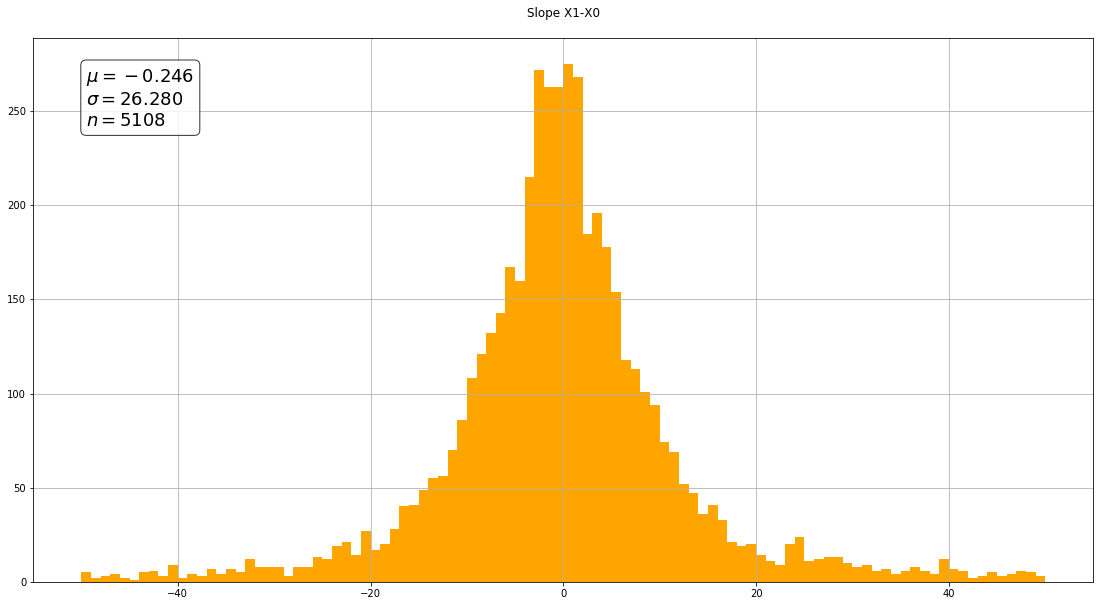

In [188]:
X_plot = []
Y_plot = []

event_hits = mc_hits[mc_hits[:,13] < events[50]]

# For each particle of a given event
for particle in event_hits:
    
    if (len(particle[5]) > 1):
        # Extract only 12 hits, as some of them are really close
        
        X_final = {}
        Zone_final = {}
        actual = -1
        found_num = 0

        # Extract all PrHits
        for i in range(0, len(particle[5])):
            if (actual != particle[8][i]):
                X_final[particle[8][i]] = []
                X_final[particle[8][i]].append(particle[5][i])
                Zone_final[particle[8][i]] = particle[12][i]
                actual = particle[8][i]
                found_num += 1
            else:
                X_final[actual].append(particle[5][i])
                
        if found_num < 12:
            continue
        
        pred_h2 = predictHeight(X_final[0][0], X_final[3][0], X_final[1][0], 1, 0, 3)
        pred_h1 = predictHeight(X_final[0][0], X_final[3][0], X_final[2][0], 2, 0, 3)

        if (pred_h1 > 0) and (pred_h1 > max_y) or (pred_h1 < 0) and (pred_h1 < min_y):
            continue
        
        if (pred_h2 > 0) and (pred_h2 > max_y) or (pred_h2 < 0) and (pred_h2 < min_y):
            continue
        
        Y_plot.append(pred_h2 - pred_h1)
        #print("Range: %f Pred: %f Found: %d" % (search_range,predicted,found_bool))

histogram(Y_plot, 'orange', -50, 50, 'Slope X1-X0', '', '')

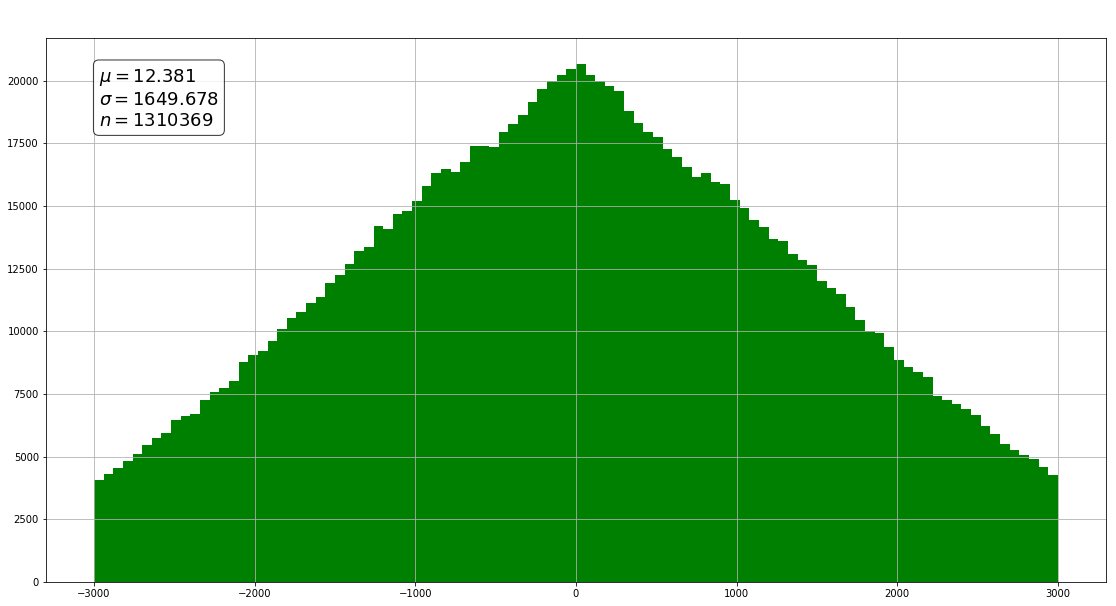

In [33]:
histogram(X_fake_data, 'green', -3000, 3000, '','','')

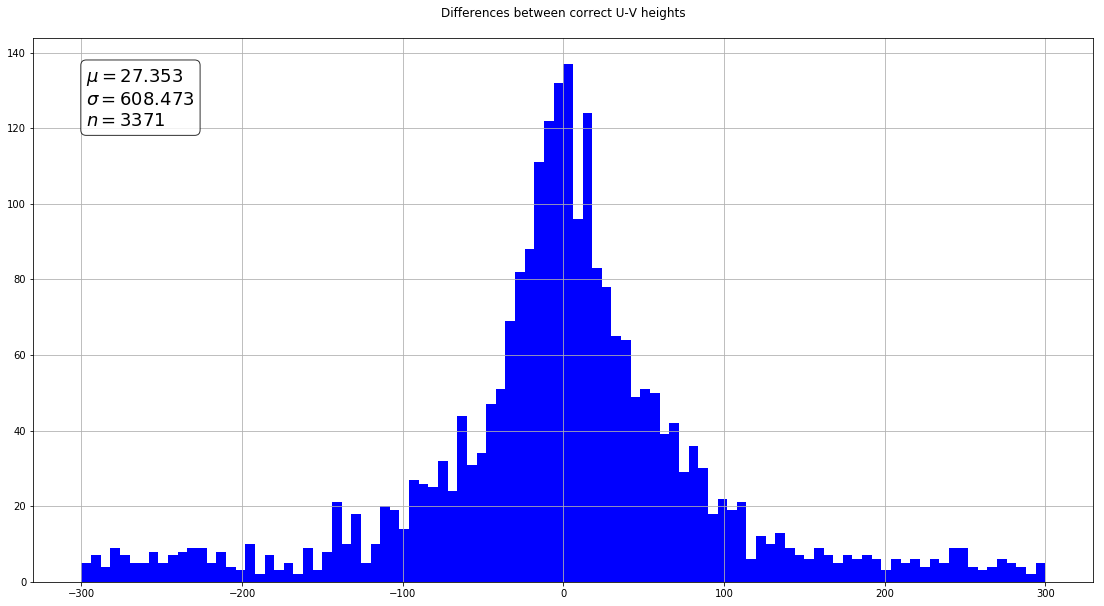

In [53]:
histogram(X_real_data, 'blue', -300, 300, 'Differences between correct U-V heights','','')

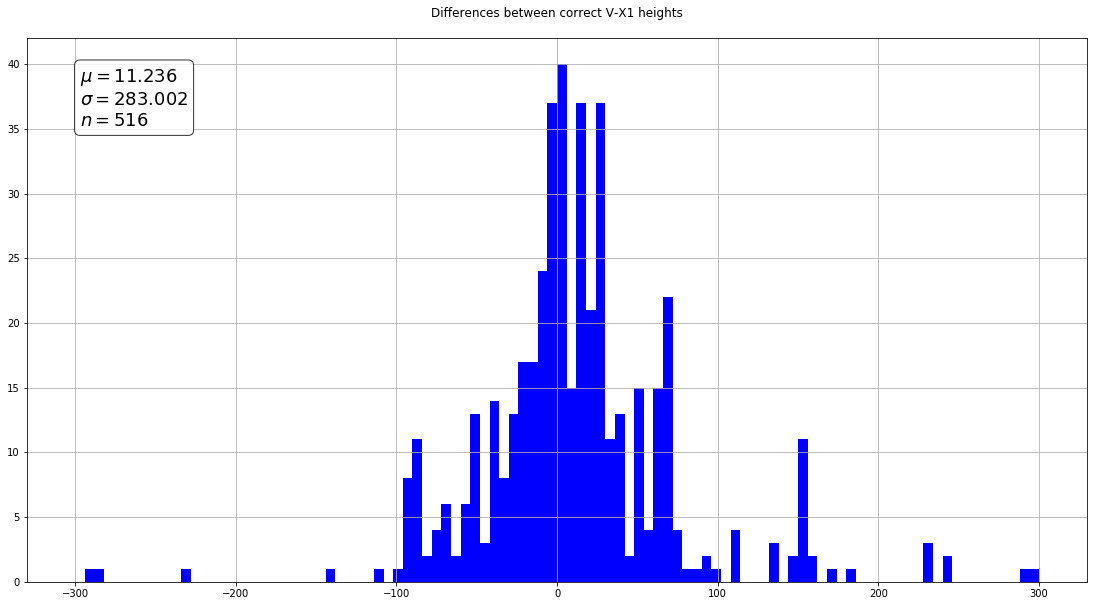

In [89]:
histogram(X_real_data, 'blue', -300, 300, 'Differences between correct V-X1 heights','','')